<a href="https://colab.research.google.com/github/ensw1031/class-codes/blob/master/webscrapy_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#imports
from bs4 import BeautifulSoup, element
import re

import requests

In [30]:
#variaveis importantes

base_url = 'https://www.raulfulgencio.com.br'

apts = []

In [32]:
# regex

check_geo_regex = re.compile('(-)*\d{2}.\d{7}') #regex pras localizações (lat e long)
check_cep_regex = re.compile('\d{5}-\d{3}') #regex pra encontrar CEP

In [37]:
def extract_cep(name):
  # name = apt['name']
  url = f"https://www.google.com/search?q={name}+Londrina"
  print(f"GET {url}")
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  
  spans = soup.find_all('span')
  address = ''
  for sp in spans:  
    if(check_cep_regex.search(sp.text) is not None):
      address = sp.text

  cep = ''
  if address:
    cep = address.split(',')[-2].strip()
    return cep
  
  return None

In [38]:
def extract_lat_long(cep):

  url = 'https://www.mapacep.com.br/index.php'
  # cep = '86020-100'
  payload = {
      'keywords': cep, 
      'sid': 'Busca+por+CEP%2C+Cidade%2C+Endere%C3%A7o%2C+CNPJ+ou+C%C3%B3d.+IBGE', 
      'submit': 'Pesquisar'
      }

  response = requests.post(url, data=payload)

  soup = BeautifulSoup(response.content, 'html.parser')

  div = soup.find('div', class_='addthis_inline_share_toolbox')

  p = div.parent.find('p')

  loc = []
  for b in p.children:
    if(type(b) == element.NavigableString and check_geo_regex.match(b.strip()) is not None):
      loc.append(b.strip())

  return(loc)



In [40]:
# função para extrair as informações do apt

def extract_apt_info(apt):
  price = apt.find('div', class_='price').find('span').text.strip()
  category = apt.find('div', class_='info').find('h3').find('a').text.strip()
  neighborhood = apt.find('div', class_='info').find('h3').find('small').text.strip()
  # print(f'{title} ({neighborhood}) {price}')
  # area = apt.find('i', class_='icon-area').parent.text.split(' ')[0]
  # bedrooms = apt.find('i', class_='icon-bedrooms')  
  # bathrooms = apt.find('i', class_='icon-bathrooms').parent.text.strio()
  # print(f'{title} ({neighborhood}) {price} - {area} ({bedrooms}, bathrooms)')
  detail_url = apt.find('a').get('href')
  # print(base_url+detail_url)
  print(f"GET {base_url}/{detail_url}")
  page = requests.get(f"{base_url}/{detail_url}")
  soup = BeautifulSoup(page.content, 'html.parser')
  name = soup.title.text.split(',')[0]
  amenities = soup.find_all('ul', class_='property-amenities-list col-md-6')
  apt = {
      'price': price,
      'category': category,
      'neighborhood': neighborhood,
      'name': name
  }

  info_dict = dict()
  for col in amenities:
    infos = col.find_all('li')
    for info in infos:
      tokens = info.text.split(':')      
      key = tokens[0].strip().lower()
      value = tokens[1].strip()
      info_dict[key] = value
      # print(f"{key}: {value}")

  if('suítes' not in info_dict):
    info_dict['suítes'] = 0
    
  if('iptu' not in info_dict):
    info_dict['iptu'] = 0

  apt['info'] = info_dict
  apt['cep'] = extract_cep(name)

  if apt['cep'] is not None:
    apt['geo_ref'] = extract_lat_long(apt['cep'])

  return apt

GET https://www.raulfulgencio.com.br/alugar/Londrina/Apartamento/Padrao/?pag=1
GET https://www.raulfulgencio.com.br/alugar/Londrina/Apartamento/Padrao/Jardim-Londrilar/6702
GET https://www.google.com/search?q=Ed Ibiuna+Londrina
b'<!doctype html><html lang="en"><head><meta charset="UTF-8"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>Ed Ibiuna Londrina - Google Search</title><script nonce="vjCTgGCvoGlxMSZoT6rKpw==">(function(){\ndocument.documentElement.addEventListener("submit",function(b){var a;if(a=b.target){var c=a.getAttribute("data-submitfalse");a="1"==c||"q"==c&&!a.elements.q.value?!0:!1}else a=!1;a&&(b.preventDefault(),b.stopPropagation())},!0);document.documentElement.addEventListener("click",function(b){var a;a:{for(a=b.target;a&&a!=document.documentElement;a=a.parentElement)if("A"==a.tagName){a="1"==a.getAttribute("data-nohref");break a}a=!1}a&&b.preventDefault()},!0);}).call(this);(function(){\nvar a=window.performance;w
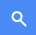
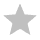
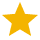
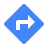
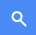
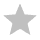
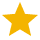
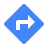
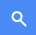
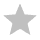
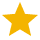
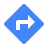
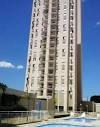
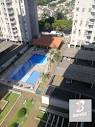
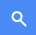
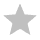
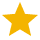
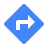
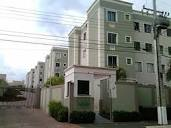
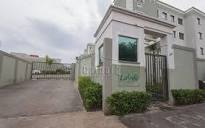
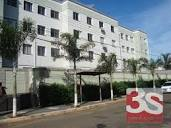
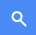
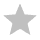
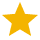
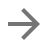
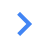
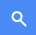
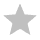
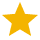
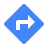
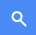
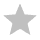
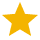
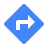
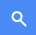
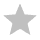
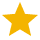
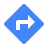
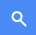
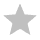
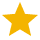
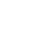
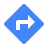
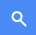
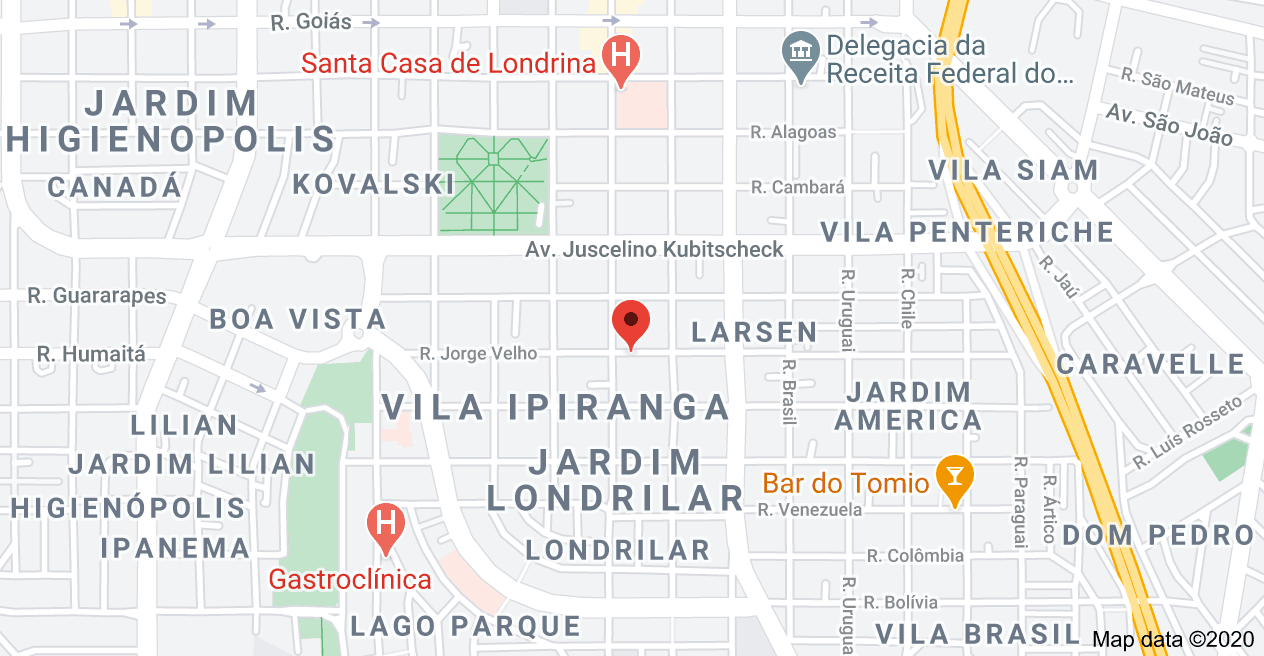
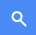
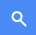
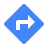
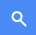
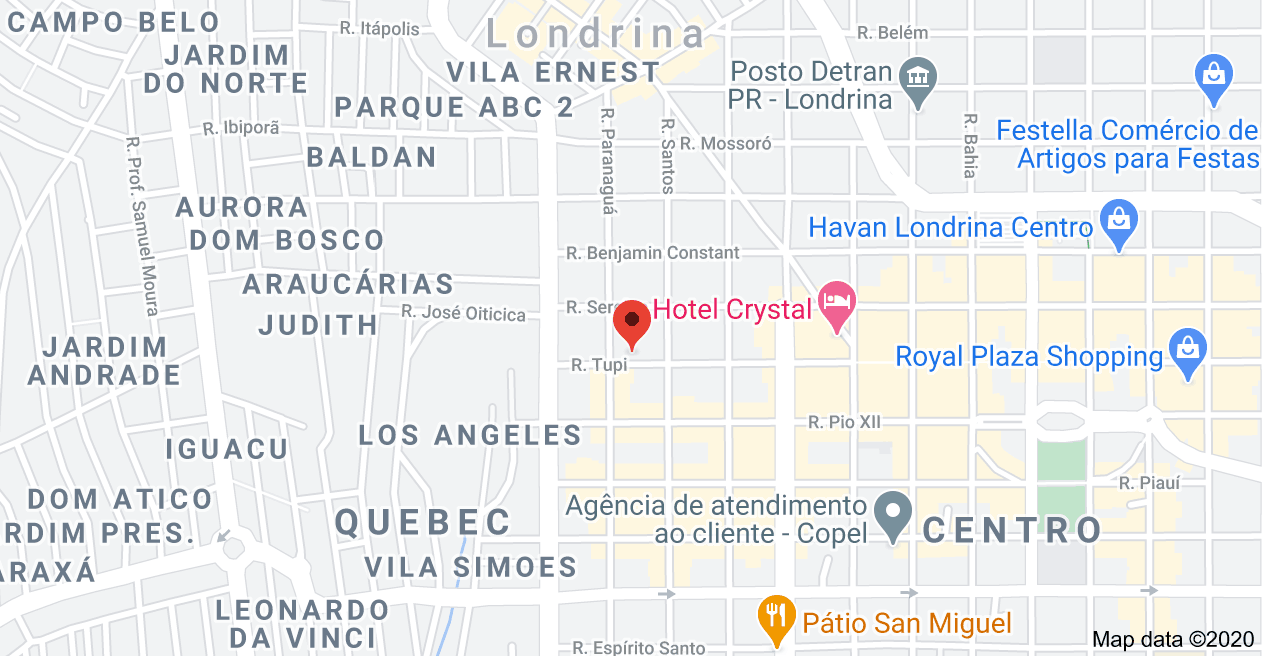
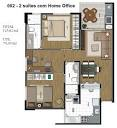
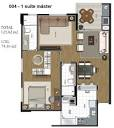
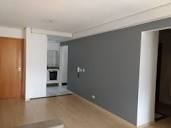
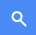
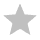
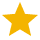
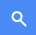
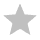
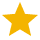
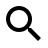
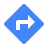
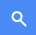
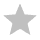
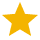
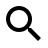
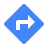

In [41]:
x = range(1, 2)
for n in x: 
  url = f"{base_url}/alugar/Londrina/Apartamento/Padrao/?pag={n}"
  print(f"GET {url}")
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  apes = soup.find_all('div', class_='item col-sm-6 col-md-4 col-lg-3')
  for ape in apes:
    price = ape.find('div', class_='price').find('span').text.strip()
    if('Consulte' not in price):    
      extract_apt = extract_apt_info(ape)
      print(extract_apt)
      apts.append(extract_apt)



In [42]:
len(apts)

16

In [46]:
apts[0]['geo_ref']

['-23.3262548', '-51.1577330']

In [4]:
import branca
import jinja2

In [6]:
import folium
m = folium.Map(location=[45.5236, -122.6750])


In [7]:
m